In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/genomics-of-drug-sensitivity-in-cancer-gdsc/Cell_Lines_Details.xlsx
/kaggle/input/genomics-of-drug-sensitivity-in-cancer-gdsc/GDSC_DATASET.csv
/kaggle/input/genomics-of-drug-sensitivity-in-cancer-gdsc/GDSC2-dataset.csv
/kaggle/input/genomics-of-drug-sensitivity-in-cancer-gdsc/Compounds-annotation.csv


In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from scipy import stats
from scipy.stats import skew, boxcox
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from category_encoders import TargetEncoder

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load the datasets
gdsc_data = pd.read_csv('/kaggle/input/genomics-of-drug-sensitivity-in-cancer-gdsc/GDSC2-dataset.csv')
cell_line_data = pd.read_excel('/kaggle/input/genomics-of-drug-sensitivity-in-cancer-gdsc/Cell_Lines_Details.xlsx', sheet_name='Cell line details')
compound_data = pd.read_csv('/kaggle/input/genomics-of-drug-sensitivity-in-cancer-gdsc/Compounds-annotation.csv')

# Display column names of each dataset to understand their structure
print(gdsc_data.columns)
print(cell_line_data.columns)
print(compound_data.columns)

Index(['DATASET', 'NLME_RESULT_ID', 'NLME_CURVE_ID', 'COSMIC_ID',
       'CELL_LINE_NAME', 'SANGER_MODEL_ID', 'TCGA_DESC', 'DRUG_ID',
       'DRUG_NAME', 'PUTATIVE_TARGET', 'PATHWAY_NAME', 'COMPANY_ID',
       'WEBRELEASE', 'MIN_CONC', 'MAX_CONC', 'LN_IC50', 'AUC', 'RMSE',
       'Z_SCORE'],
      dtype='object')
Index(['Sample Name', 'COSMIC identifier', 'Whole Exome Sequencing (WES)',
       'Copy Number Alterations (CNA)', 'Gene Expression', 'Methylation',
       'Drug\nResponse', 'GDSC\nTissue descriptor 1',
       'GDSC\nTissue\ndescriptor 2', 'Cancer Type\n(matching TCGA label)',
       'Microsatellite \ninstability Status (MSI)', 'Screen Medium',
       'Growth Properties'],
      dtype='object')
Index(['DRUG_ID', 'SCREENING_SITE', 'DRUG_NAME', 'SYNONYMS', 'TARGET',
       'TARGET_PATHWAY'],
      dtype='object')


In [4]:
# For GDSC2-dataset, keep these columns:
gdsc_columns = ['COSMIC_ID', 'CELL_LINE_NAME', 'TCGA_DESC', 'DRUG_ID', 'DRUG_NAME', 
                'PUTATIVE_TARGET', 'PATHWAY_NAME', 'LN_IC50', 'AUC', 'Z_SCORE']

# For Cell-line-data, we'll join on 'COSMIC identifier' and keep:
cell_columns = ['COSMIC identifier', 'Sample Name', 'GDSC\nTissue descriptor 1', 
                'GDSC\nTissue\ndescriptor 2', 'Cancer Type\n(matching TCGA label)', 
                'Microsatellite \ninstability Status (MSI)', 'Screen Medium', 'Growth Properties',
                'Whole Exome Sequencing (WES)','Copy Number Alterations (CNA)', 'Gene Expression', 'Methylation']

# For Compounds-annotation, we'll join on 'DRUG_ID' and keep:
compound_columns = ['DRUG_ID', 'TARGET', 'TARGET_PATHWAY']

# Select relevant columns
gdsc_data = gdsc_data[gdsc_columns]
cell_line_data = cell_line_data[cell_columns]
compound_data = compound_data[compound_columns]

# Rename columns for consistency
cell_line_data = cell_line_data.rename(columns={'COSMIC identifier': 'COSMIC_ID', 'Sample Name': 'CELL_LINE_NAME' ,
                                                'GDSC\nTissue descriptor 1':'GDSC Tissue descriptor 1',
                                                'GDSC\nTissue\ndescriptor 2':'GDSC Tissue descriptor 2',
                                                'Cancer Type\n(matching TCGA label)':'Cancer Type (matching TCGA label)',
                                                'Microsatellite \ninstability Status (MSI)':'Microsatellite instability Status (MSI)',
                                                'Whole Exome Sequencing (WES)': 'WES',
                                                'Copy Number Alterations (CNA)': 'CNA'
                                               })

In [5]:
# Merge GDSC2-dataset with Cell-line-annotation
merged_data = pd.merge(gdsc_data, cell_line_data, on=['COSMIC_ID', 'CELL_LINE_NAME'], how='left')

# Merge with Compounds-annotation
final_data = pd.merge(merged_data, compound_data, on='DRUG_ID', how='left')

In [6]:
# Check the shape of the final dataset
print(final_data.shape)

(242036, 22)


In [7]:
duplicated_rows = final_data.duplicated()
sum(duplicated_rows)

0

In [8]:
# Display the first few rows to verify the merge
final_data.head().T

,0,1,2,3,4
COSMIC_ID,683667,684052,684057,684059,684062
CELL_LINE_NAME,PFSK-1,A673,ES5,ES7,EW-11
TCGA_DESC,MB,UNCLASSIFIED,UNCLASSIFIED,UNCLASSIFIED,UNCLASSIFIED
DRUG_ID,1003,1003,1003,1003,1003
DRUG_NAME,Camptothecin,Camptothecin,Camptothecin,Camptothecin,Camptothecin
PUTATIVE_TARGET,TOP1,TOP1,TOP1,TOP1,TOP1
PATHWAY_NAME,DNA replication,DNA replication,DNA replication,DNA replication,DNA replication
LN_IC50,-1.463887,-4.869455,-3.360586,-5.04494,-3.741991
AUC,0.93022,0.61497,0.791072,0.59266,0.734047
Z_SCORE,0.433123,-1.4211,-0.599569,-1.516647,-0.807232


In [9]:
# Remove redundant features 
GDSC_DATASET = final_data.drop(columns=['PUTATIVE_TARGET','PATHWAY_NAME','WES'], index=1)

In [10]:
GDSC_DATASET.shape

(242035, 19)

In [11]:
GDSC_DATASET.to_csv('GDSC_DATASET.csv',index=False)

In [12]:
# Load the datasets
Data = pd.read_csv('/kaggle/working/GDSC_DATASET.csv')

# Display column names of each dataset to understand their structure
print(Data.columns)

Index(['COSMIC_ID', 'CELL_LINE_NAME', 'TCGA_DESC', 'DRUG_ID', 'DRUG_NAME',
       'LN_IC50', 'AUC', 'Z_SCORE', 'GDSC Tissue descriptor 1',
       'GDSC Tissue descriptor 2', 'Cancer Type (matching TCGA label)',
       'Microsatellite instability Status (MSI)', 'Screen Medium',
       'Growth Properties', 'CNA', 'Gene Expression', 'Methylation', 'TARGET',
       'TARGET_PATHWAY'],
      dtype='object')


In [13]:
# information about the data 
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242035 entries, 0 to 242034
Data columns (total 19 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   COSMIC_ID                                242035 non-null  int64  
 1   CELL_LINE_NAME                           242035 non-null  object 
 2   TCGA_DESC                                240968 non-null  object 
 3   DRUG_ID                                  242035 non-null  int64  
 4   DRUG_NAME                                242035 non-null  object 
 5   LN_IC50                                  242035 non-null  float64
 6   AUC                                      242035 non-null  float64
 7   Z_SCORE                                  242035 non-null  float64
 8   GDSC Tissue descriptor 1                 232669 non-null  object 
 9   GDSC Tissue descriptor 2                 232669 non-null  object 
 10  Cancer Type (matching TCGA label

In [14]:
# Check statistical information of Numeric Features
numeric_features = Data.select_dtypes(include=[np.number])
Data.describe(include=[np.number]).transpose()

,count,mean,std,min,25%,50%,75%,max
COSMIC_ID,242035.0,992107.148487,220981.426065,683667.000000,906805.000000,909720.000000,1.240144e+06,1.789883e+06
DRUG_ID,242035.0,1594.044886,398.739728,1003.000000,1149.000000,1631.000000,1.912000e+03,2.499000e+03
LN_IC50,242035.0,2.817111,2.762191,-8.747724,1.508054,3.236744,4.700111e+00,1.382019e+01
AUC,242035.0,0.882593,0.146998,0.006282,0.849452,0.944197,9.749340e-01,9.989040e-01
Z_SCORE,242035.0,0.000006,0.999390,-8.254501,-0.656842,0.010585,6.560365e-01,7.978776e+00


In [15]:
# Check statistical information of Categorical Features
categorical_features = Data.select_dtypes(include=object)
Data.describe(include=object).transpose()

,count,unique,top,freq
CELL_LINE_NAME,242035,969,HT-29,295
TCGA_DESC,240968,32,UNCLASSIFIED,45690
DRUG_NAME,242035,286,Ulixertinib,1698
GDSC Tissue descriptor 1,232669,19,lung_NSCLC,26977
GDSC Tissue descriptor 2,232669,54,lung_NSCLC_adenocarcinoma,16112
Cancer Type (matching TCGA label),190589,31,LUAD,15483
Microsatellite instability Status (MSI),229682,2,MSS/MSI-L,214104
Screen Medium,232669,2,R,129756
Growth Properties,232669,3,Adherent,168430
CNA,232669,2,Y,231651


In [16]:
unique_drugs = Data["DRUG_NAME"].unique()
unique_drug_list = unique_drugs.tolist()
unique_drug_list

['Camptothecin',
 'Vinblastine',
 'Cisplatin',
 'Cytarabine',
 'Docetaxel',
 'Methotrexate',
 'Tretinoin',
 'Gefitinib',
 'Navitoclax',
 'Vorinostat',
 'Nilotinib',
 'Refametinib',
 'Temsirolimus',
 'Olaparib',
 'Veliparib',
 'Bosutinib',
 'Lenalidomide',
 'Axitinib',
 'AZD7762',
 'GW441756',
 'Lestaurtinib',
 'SB216763',
 'Tanespimycin',
 'Motesanib',
 'KU-55933',
 'Elesclomol',
 'Afatinib',
 'Vismodegib',
 'Staurosporine',
 'PLX-4720',
 'BX795',
 'NU7441',
 'SL0101',
 'Doramapimod',
 'JNK Inhibitor VIII',
 'Wee1 Inhibitor',
 'Nutlin-3a (-)',
 'Mirin',
 'PD173074',
 'ZM447439',
 'Alisertib',
 'RO-3306',
 'MK-2206',
 'Palbociclib',
 'Dactolisib',
 'Pictilisib',
 'AZD8055',
 'PD0325901',
 'SB590885',
 'Selumetinib',
 'CCT007093',
 'Obatoclax Mesylate',
 'EHT-1864',
 'Avagacestat',
 '5-Fluorouracil',
 'Dasatinib',
 'Paclitaxel',
 'Crizotinib',
 'Rapamycin',
 'Sorafenib',
 'BI-2536',
 'Irinotecan',
 'Oxaliplatin',
 'BMS-536924',
 'GSK1904529A',
 'Tozasertib',
 'PF-4708671',
 'PRIMA-1MET',

In [17]:
top_10_drugs = Data["DRUG_NAME"].value_counts().head(10)
print("\nTop 10 Most Frequent Drugs:\n", top_10_drugs)


Top 10 Most Frequent Drugs:
 DRUG_NAME
Ulixertinib     1698
Oxaliplatin     1684
Fulvestrant     1680
Selumetinib     1666
Dactinomycin    1659
Docetaxel       1637
GSK343          1634
Uprosertib      1634
Acetalax        1434
MG-132           969
Name: count, dtype: int64


In [18]:
# Count occurrences of each drug name
top_10_cancer = Data["Cancer Type (matching TCGA label)"].value_counts().head(10)
print("\nTop 10 Most Caner Types:\n", top_10_cancer)


Top 10 Most Caner Types:
 Cancer Type (matching TCGA label)
LUAD         15483
SCLC         13750
BRCA         13106
COAD/READ    12438
SKCM         12097
HNSC          9178
ESCA          9126
GBM           8384
OV            8166
DLBC          7978
Name: count, dtype: int64


# Data Cleaning 

In [19]:
duplicated_rows = Data.duplicated()
sum(duplicated_rows)

0

In [20]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

# Print initial missing values summary
print("Initial Missing Value Analysis")
print("-" * 50)
missing_summary = Data.isnull().sum()
missing_percentage = (Data.isnull().sum() / len(Data)) * 100

missing_analysis = pd.DataFrame({
    'Missing Values': missing_summary,
    'Percentage Missing': missing_percentage.round(2)
})
print(missing_analysis)

Initial Missing Value Analysis
--------------------------------------------------
                                         Missing Values  Percentage Missing
COSMIC_ID                                             0                0.00
CELL_LINE_NAME                                        0                0.00
TCGA_DESC                                          1067                0.44
DRUG_ID                                               0                0.00
DRUG_NAME                                             0                0.00
LN_IC50                                               0                0.00
AUC                                                   0                0.00
Z_SCORE                                               0                0.00
GDSC Tissue descriptor 1                           9366                3.87
GDSC Tissue descriptor 2                           9366                3.87
Cancer Type (matching TCGA label)                 51446               21.26
Micros

In [21]:
# Store duplicate analysis results
duplicate_analysis = {}

for drug in Data['DRUG_NAME'].unique():
    drug_subset = Data[Data['DRUG_NAME'] == drug]
    
    # Check for exact duplicates
    exact_dupes = drug_subset.duplicated().sum()
    
    # Check for potential duplicates
    potential_dupes = drug_subset.groupby('CELL_LINE_NAME').size()
    potential_dupes = potential_dupes[potential_dupes > 1]
    
    duplicate_analysis[drug] = {
        'exact_duplicates': exact_dupes,
        'potential_duplicates': len(potential_dupes),
        'affected_cell_lines': potential_dupes.index.tolist() if len(potential_dupes) > 0 else []
    }

# Print duplicate analysis results
print("Duplicate Analysis Results")
print("-" * 50)
print(f"Total number of records: {len(Data)}")
print(f"Number of unique drugs: {Data['DRUG_NAME'].nunique()}")

total_exact_dupes = sum(info['exact_duplicates'] for info in duplicate_analysis.values())
total_potential_dupes = sum(info['potential_duplicates'] for info in duplicate_analysis.values())

print(f"\nTotal exact duplicates across all drugs: {total_exact_dupes}")
print(f"Total potential duplicates across all drugs: {total_potential_dupes}")

# Print detailed drug analysis
print("\nDetailed Drug-by-Drug Analysis:")
print("-" * 50)
for drug, info in duplicate_analysis.items():
    if info['exact_duplicates'] > 0 or info['potential_duplicates'] > 0:
        print(f"\nDrug: {drug}")
        print(f"Exact duplicates: {info['exact_duplicates']}")
        print(f"Potential duplicates: {info['potential_duplicates']}")
        if info['affected_cell_lines']:
            print("Affected cell lines:")
            for cell_line in info['affected_cell_lines'][:5]:
                print(f"- {cell_line}")
            if len(info['affected_cell_lines']) > 5:
                print(f"... and {len(info['affected_cell_lines'])-5} more")

Duplicate Analysis Results
--------------------------------------------------
Total number of records: 242035
Number of unique drugs: 286

Total exact duplicates across all drugs: 0
Total potential duplicates across all drugs: 6288

Detailed Drug-by-Drug Analysis:
--------------------------------------------------

Drug: Docetaxel
Exact duplicates: 0
Potential duplicates: 669
Affected cell lines:
- 22RV1
- 23132-87
- 42-MG-BA
- 5637
- 639-V
... and 664 more

Drug: Selumetinib
Exact duplicates: 0
Potential duplicates: 699
Affected cell lines:
- 22RV1
- 23132-87
- 42-MG-BA
- 5637
- 639-V
... and 694 more

Drug: Oxaliplatin
Exact duplicates: 0
Potential duplicates: 717
Affected cell lines:
- 22RV1
- 23132-87
- 42-MG-BA
- 5637
- 639-V
... and 712 more

Drug: Fulvestrant
Exact duplicates: 0
Potential duplicates: 715
Affected cell lines:
- 22RV1
- 23132-87
- 42-MG-BA
- 5637
- 639-V
... and 710 more

Drug: Uprosertib
Exact duplicates: 0
Potential duplicates: 668
Affected cell lines:
- 22RV1
-

In [22]:
# Create a copy of the dataframe
imputed_df = Data.copy()

# First handle numeric columns since we know their structure
numeric_cols = ['LN_IC50', 'AUC', 'Z_SCORE', 'CNA', 'Gene Expression', 'Methylation']
numeric_df = imputed_df[numeric_cols].copy()

# Convert Y/N to 1/0 in relevant columns
for col in ['CNA', 'Gene Expression', 'Methylation']:
    numeric_df[col] = numeric_df[col].replace({'Y': 1, 'N': 0})
    numeric_df[col] = pd.to_numeric(numeric_df[col], errors='coerce')

# Apply KNN imputation to numeric columns
knn_imputer = KNNImputer(n_neighbors=5)
imputed_numeric = pd.DataFrame(
    knn_imputer.fit_transform(numeric_df),
    columns=numeric_cols,
    index=numeric_df.index
)
imputed_df[numeric_cols] = imputed_numeric

# Now handle categorical columns
categorical_cols = [
    'TCGA_DESC',
    'GDSC Tissue descriptor 1',
    'GDSC Tissue descriptor 2',
    'Cancer Type (matching TCGA label)',
    'Microsatellite instability Status (MSI)',
    'Screen Medium',
    'Growth Properties',
    'TARGET',
    'TARGET_PATHWAY'
]

# First, fill TARGET based on DRUG_NAME since it's drug-specific
for drug in imputed_df['DRUG_NAME'].unique():
    drug_mask = imputed_df['DRUG_NAME'] == drug
    target_value = imputed_df.loc[drug_mask, 'TARGET'].mode().iloc[0] if not imputed_df.loc[drug_mask, 'TARGET'].mode().empty else 'Unknown'
    imputed_df.loc[drug_mask, 'TARGET'] = imputed_df.loc[drug_mask, 'TARGET'].fillna(target_value)

# For tissue-related columns, impute based on hierarchical relationships
tissue_cols = [
    'GDSC Tissue descriptor 1',
    'GDSC Tissue descriptor 2',
    'Cancer Type (matching TCGA label)',
    'TCGA_DESC'
]

# Fill tissue information based on CELL_LINE_NAME
for col in tissue_cols:
    cell_line_mode = imputed_df.groupby('CELL_LINE_NAME')[col].transform(
        lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown'
    )
    imputed_df[col] = imputed_df[col].fillna(cell_line_mode)

# Fill remaining categorical columns
remaining_cats = [col for col in categorical_cols if col not in tissue_cols + ['TARGET']]
for col in remaining_cats:
    # First try to fill based on tissue descriptor
    tissue_based = imputed_df.groupby('GDSC Tissue descriptor 1')[col].transform(
        lambda x: x.mode().iloc[0] if not x.mode().empty else None
    )
    imputed_df[col] = imputed_df[col].fillna(tissue_based)
    
    # If any still missing, fill with overall mode
    overall_mode = imputed_df[col].mode().iloc[0] if not imputed_df[col].mode().empty else 'Unknown'
    imputed_df[col] = imputed_df[col].fillna(overall_mode)

# Print missing values after imputation
print("Missing Values After Imputation:")
print("-" * 50)
print(imputed_df.isnull().sum())

# Print sample of imputed values for verification
print("\nSample of imputed values:")
for col in categorical_cols:
    print(f"\n{col} unique values:", imputed_df[col].unique()[:5])

Missing Values After Imputation:
--------------------------------------------------
COSMIC_ID                                  0
CELL_LINE_NAME                             0
TCGA_DESC                                  0
DRUG_ID                                    0
DRUG_NAME                                  0
LN_IC50                                    0
AUC                                        0
Z_SCORE                                    0
GDSC Tissue descriptor 1                   0
GDSC Tissue descriptor 2                   0
Cancer Type (matching TCGA label)          0
Microsatellite instability Status (MSI)    0
Screen Medium                              0
Growth Properties                          0
CNA                                        0
Gene Expression                            0
Methylation                                0
TARGET                                     0
TARGET_PATHWAY                             0
dtype: int64

Sample of imputed values:

TCGA_DESC unique val

In [23]:
cleaned_df = pd.DataFrame()

for drug in imputed_df['DRUG_NAME'].unique():
    drug_subset = imputed_df[imputed_df['DRUG_NAME'] == drug].copy()
    
    # Handle exact duplicates first
    drug_subset = drug_subset.drop_duplicates()
    
    # Handle potential duplicates
    duplicate_groups = drug_subset.groupby('CELL_LINE_NAME')
    
    cleaned_drug_data = []
    for _, group in duplicate_groups:
        if len(group) > 1:
            # Resolve multiple measurements
            resolved_row = pd.DataFrame({
                'COSMIC_ID': group['COSMIC_ID'].iloc[0],
                'CELL_LINE_NAME': group['CELL_LINE_NAME'].iloc[0],
                'DRUG_ID': group['DRUG_ID'].iloc[0],
                'DRUG_NAME': group['DRUG_NAME'].iloc[0],
                'LN_IC50': group['LN_IC50'].mean(),
                'AUC': group['AUC'].mean(),
                'Z_SCORE': group['Z_SCORE'].mean(),
                'TCGA_DESC': group['TCGA_DESC'].mode().iloc[0],
                'GDSC Tissue descriptor 1': group['GDSC Tissue descriptor 1'].mode().iloc[0],
                'GDSC Tissue descriptor 2': group['GDSC Tissue descriptor 2'].mode().iloc[0],
                'Cancer Type (matching TCGA label)': group['Cancer Type (matching TCGA label)'].mode().iloc[0],
                'Microsatellite instability Status (MSI)': group['Microsatellite instability Status (MSI)'].mode().iloc[0],
                'Screen Medium': group['Screen Medium'].mode().iloc[0],
                'Growth Properties': group['Growth Properties'].mode().iloc[0],
                'CNA': group['CNA'].mean(),
                'Gene Expression': group['Gene Expression'].mean(),
                'Methylation': group['Methylation'].mean(),
                'TARGET': group['TARGET'].mode().iloc[0],
                'TARGET_PATHWAY': group['TARGET_PATHWAY'].mode().iloc[0]
            }, index=[0])
        else:
            resolved_row = group
            
        cleaned_drug_data.append(resolved_row)
        
    cleaned_drug_subset = pd.concat(cleaned_drug_data, ignore_index=True)
    cleaned_df = pd.concat([cleaned_df, cleaned_drug_subset], ignore_index=True)

# Print final cleaning results
print("Final Cleaning Results")
print("-" * 50)
print(f"Original dataset size: {len(Data)}")
print(f"Cleaned dataset size: {len(cleaned_df)}")
print(f"Records removed: {len(Data) - len(cleaned_df)}")

# Print statistics for key numeric columns
numeric_cols = ['LN_IC50', 'AUC', 'Z_SCORE']
print("\nFeature Statistics Before and After Cleaning:")
for col in numeric_cols:
    print(f"\n{col} Statistics:")
    print("Before:")
    print(Data[col].describe())
    print("\nAfter:")
    print(cleaned_df[col].describe())

Final Cleaning Results
--------------------------------------------------
Original dataset size: 242035
Cleaned dataset size: 235747
Records removed: 6288

Feature Statistics Before and After Cleaning:

LN_IC50 Statistics:
Before:
count    242035.000000
mean          2.817111
std           2.762191
min          -8.747724
25%           1.508054
50%           3.236744
75%           4.700111
max          13.820189
Name: LN_IC50, dtype: float64

After:
count    235747.000000
mean          2.835384
std           2.733539
min          -8.642551
25%           1.520423
50%           3.246789
75%           4.699744
max          13.820189
Name: LN_IC50, dtype: float64

AUC Statistics:
Before:
count    242035.000000
mean          0.882593
std           0.146998
min           0.006282
25%           0.849452
50%           0.944197
75%           0.974934
max           0.998904
Name: AUC, dtype: float64

After:
count    235747.000000
mean          0.883112
std           0.144002
min           0.00628

In [24]:
cleaned_df.isnull().sum()

COSMIC_ID                                  0
CELL_LINE_NAME                             0
TCGA_DESC                                  0
DRUG_ID                                    0
DRUG_NAME                                  0
LN_IC50                                    0
AUC                                        0
Z_SCORE                                    0
GDSC Tissue descriptor 1                   0
GDSC Tissue descriptor 2                   0
Cancer Type (matching TCGA label)          0
Microsatellite instability Status (MSI)    0
Screen Medium                              0
Growth Properties                          0
CNA                                        0
Gene Expression                            0
Methylation                                0
TARGET                                     0
TARGET_PATHWAY                             0
dtype: int64

In [25]:
cleaned_df.head().T

,0,1,2,3,4
COSMIC_ID,924100,910924,687561,1287706,687452
CELL_LINE_NAME,22RV1,23132-87,42-MG-BA,451Lu,5637
TCGA_DESC,PRAD,STAD,GBM,SKCM,BLCA
DRUG_ID,1003,1003,1003,1003,1003
DRUG_NAME,Camptothecin,Camptothecin,Camptothecin,Camptothecin,Camptothecin
LN_IC50,-2.903667,-2.757644,-3.40022,-0.948763,-2.632632
AUC,0.783025,0.836042,0.777517,0.943027,0.834067
Z_SCORE,-0.350791,-0.271286,-0.621149,0.713592,-0.203221
GDSC Tissue descriptor 1,urogenital_system,digestive_system,nervous_system,skin,Unknown
GDSC Tissue descriptor 2,prostate,stomach,glioma,melanoma,Unknown


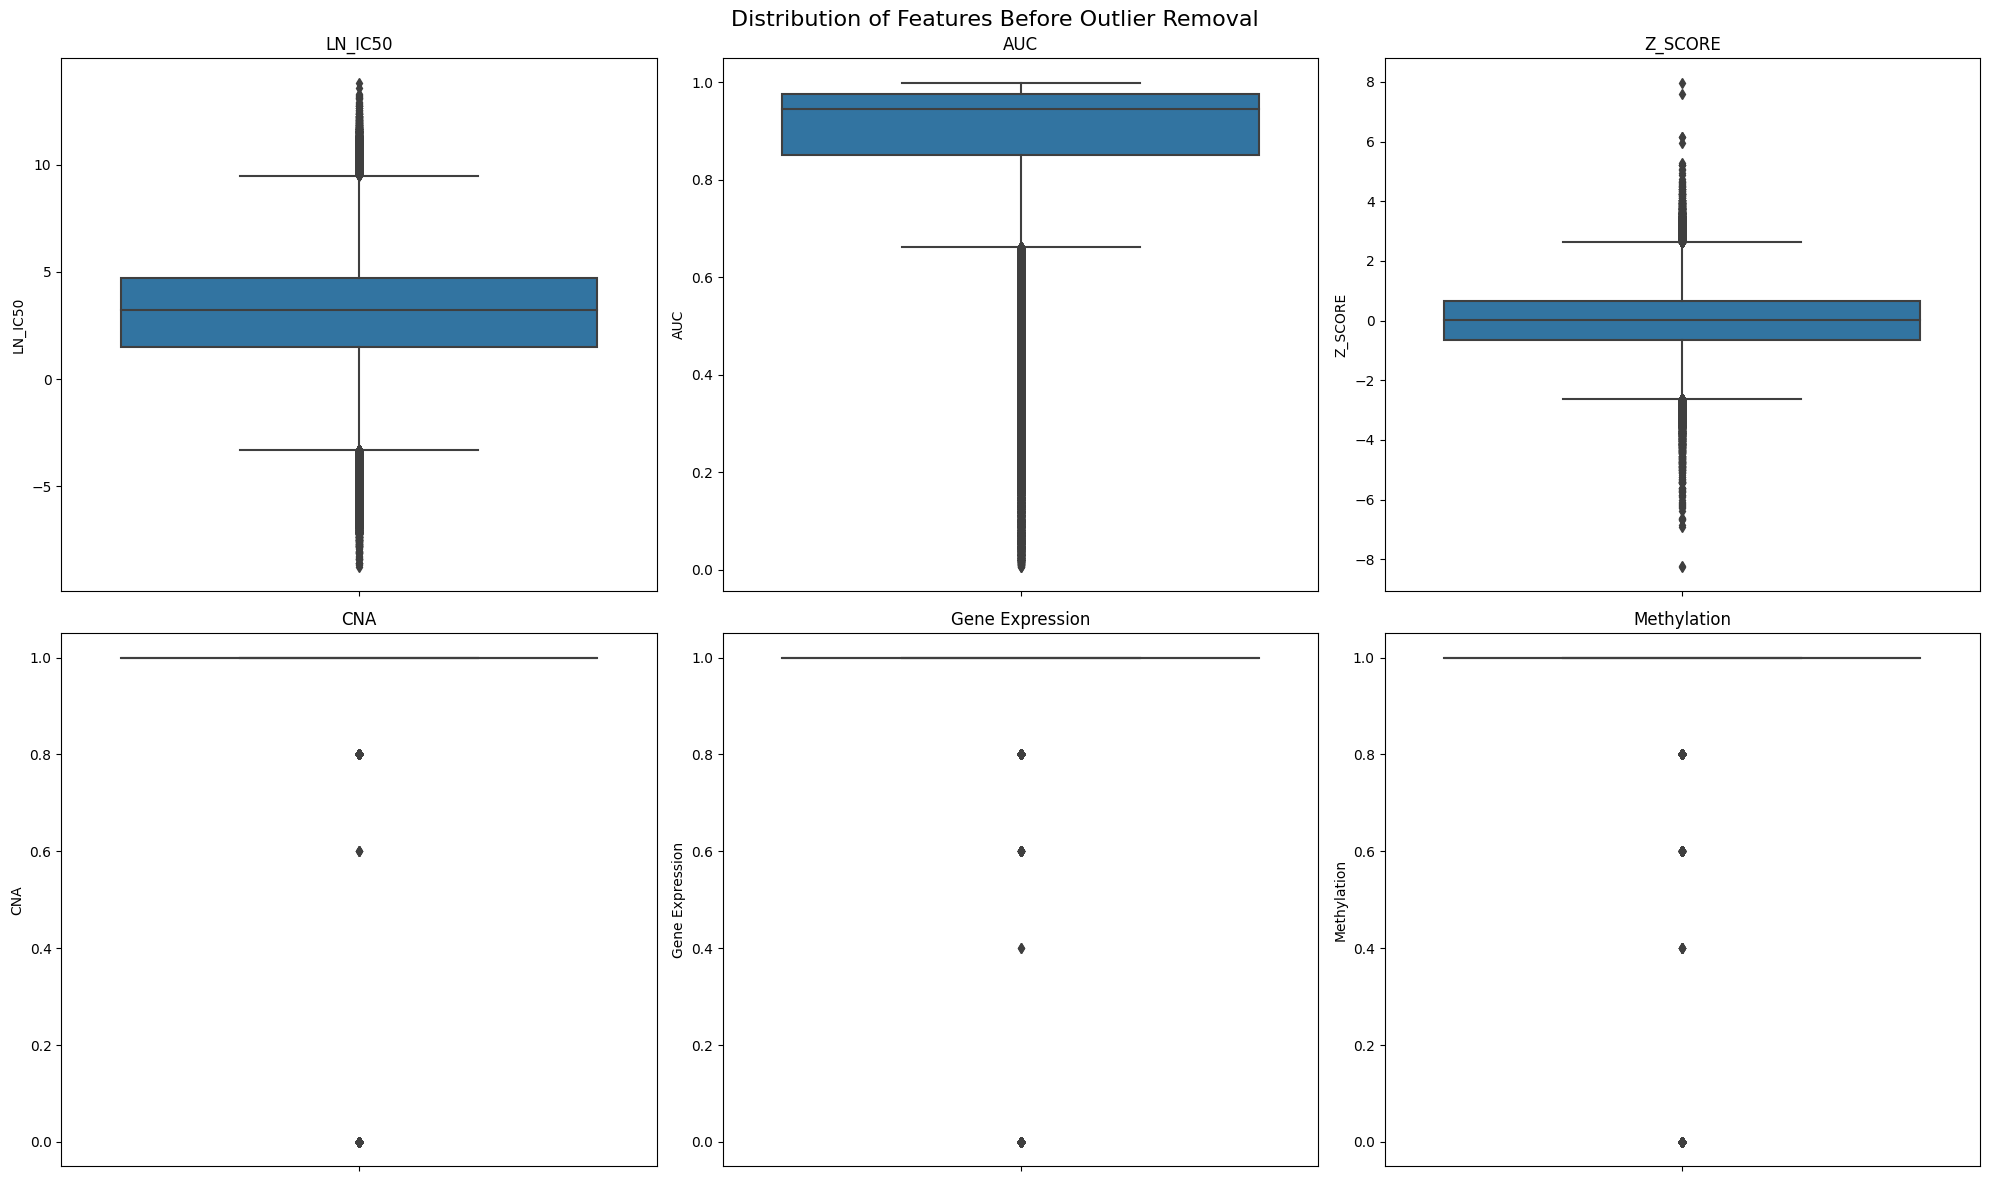


Outlier Analysis:
--------------------------------------------------

LN_IC50:
Number of outliers: 11542
Percentage of outliers: 4.77%
Range for non-outliers: [-3.280, 9.488]

AUC:
Number of outliers: 20053
Percentage of outliers: 8.29%
Range for non-outliers: [0.661, 1.163]

Z_SCORE:
Number of outliers: 2996
Percentage of outliers: 1.24%
Range for non-outliers: [-2.626, 2.625]

CNA:
Number of outliers: 1269
Percentage of outliers: 0.52%
Range for non-outliers: [1.000, 1.000]

Gene Expression:
Number of outliers: 5694
Percentage of outliers: 2.35%
Range for non-outliers: [1.000, 1.000]

Methylation:
Number of outliers: 9068
Percentage of outliers: 3.75%
Range for non-outliers: [1.000, 1.000]


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Numeric columns to check for outliers
numeric_cols = ['LN_IC50', 'AUC', 'Z_SCORE', 'CNA', 'Gene Expression', 'Methylation']

# Create box plots before outlier removal
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Distribution of Features Before Outlier Removal', fontsize=16)

for idx, col in enumerate(numeric_cols):
    row = idx // 3
    col_idx = idx % 3
    sns.boxplot(data=imputed_df, y=col, ax=axes[row, col_idx])
    axes[row, col_idx].set_title(col)

plt.tight_layout()
plt.show()

# Calculate and display outliers for each numeric column
print("\nOutlier Analysis:")
print("-" * 50)

outlier_stats = {}
for col in numeric_cols:
    Q1 = imputed_df[col].quantile(0.25)
    Q3 = imputed_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = imputed_df[(imputed_df[col] < lower_bound) | (imputed_df[col] > upper_bound)]
    
    outlier_stats[col] = {
        'total_outliers': len(outliers),
        'percentage_outliers': (len(outliers) / len(imputed_df)) * 100,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }
    
    print(f"\n{col}:")
    print(f"Number of outliers: {len(outliers)}")
    print(f"Percentage of outliers: {(len(outliers) / len(imputed_df)) * 100:.2f}%")
    print(f"Range for non-outliers: [{lower_bound:.3f}, {upper_bound:.3f}]")

In [27]:
# Create copy of dataframe for outlier removal
df_no_outliers = imputed_df.copy()

# Remove outliers for each numeric column
rows_before = len(df_no_outliers)

for col in numeric_cols:
    Q1 = df_no_outliers[col].quantile(0.25)
    Q3 = df_no_outliers[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df_no_outliers = df_no_outliers[
        (df_no_outliers[col] >= lower_bound) & 
        (df_no_outliers[col] <= upper_bound)
    ]

rows_after = len(df_no_outliers)

print("Impact of Outlier Removal:")
print("-" * 50)
print(f"Rows before outlier removal: {rows_before}")
print(f"Rows after outlier removal: {rows_after}")
print(f"Total rows removed: {rows_before - rows_after}")
print(f"Percentage of data removed: {((rows_before - rows_after) / rows_before) * 100:.2f}%")

Impact of Outlier Removal:
--------------------------------------------------
Rows before outlier removal: 242035
Rows after outlier removal: 198342
Total rows removed: 43693
Percentage of data removed: 18.05%


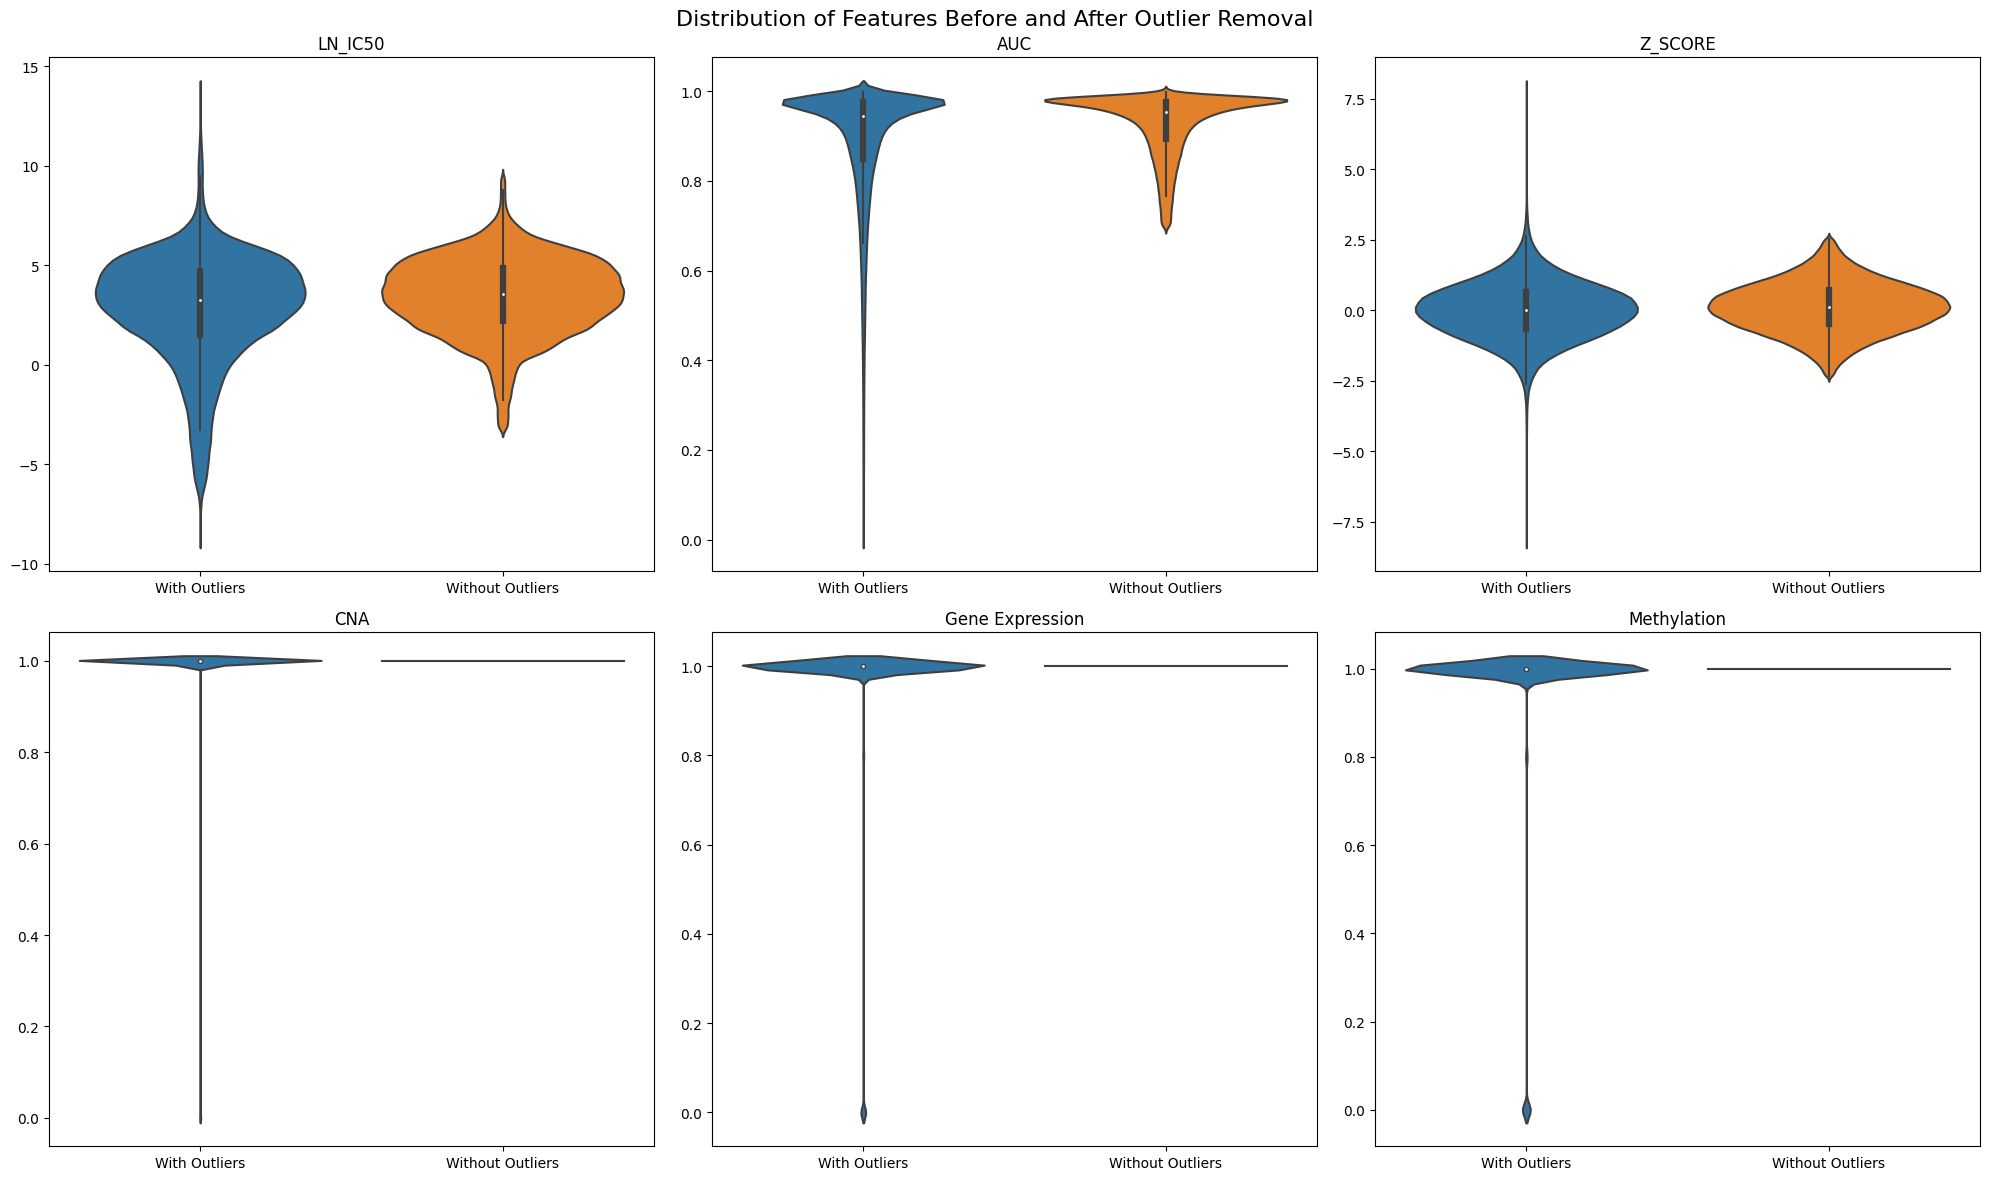


Summary Statistics Comparison:
--------------------------------------------------

LN_IC50:

Before outlier removal:
count    242035.000000
mean          2.817111
std           2.762191
min          -8.747724
25%           1.508054
50%           3.236744
75%           4.700111
max          13.820189
Name: LN_IC50, dtype: float64

After outlier removal:
count    198342.000000
mean          3.439308
std           1.939685
min          -3.278775
25%           2.204931
50%           3.557504
75%           4.840144
max           9.487697
Name: LN_IC50, dtype: float64

AUC:

Before outlier removal:
count    242035.000000
mean          0.882593
std           0.146998
min           0.006282
25%           0.849452
50%           0.944197
75%           0.974934
max           0.998904
Name: AUC, dtype: float64

After outlier removal:
count    198342.000000
mean          0.924904
std           0.070389
min           0.696149
25%           0.892726
50%           0.954348
75%           0.977122
max 

In [28]:
# Create comparison box plots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Distribution of Features Before and After Outlier Removal', fontsize=16)

for idx, col in enumerate(numeric_cols):
    row = idx // 3
    col_idx = idx % 3
    
    # Create violin plots with box plots inside
    sns.violinplot(data=[imputed_df[col], df_no_outliers[col]], ax=axes[row, col_idx])
    axes[row, col_idx].set_xticklabels(['With Outliers', 'Without Outliers'])
    axes[row, col_idx].set_title(col)

plt.tight_layout()
plt.show()

# Display summary statistics before and after outlier removal
print("\nSummary Statistics Comparison:")
print("-" * 50)
for col in numeric_cols:
    print(f"\n{col}:")
    print("\nBefore outlier removal:")
    print(imputed_df[col].describe())
    print("\nAfter outlier removal:")
    print(df_no_outliers[col].describe())

In [29]:
# Save the cleaned dataset without outliers
df_no_outliers.to_csv('cleaned_data_no_outliers.csv', index=False)
print("\nCleaned dataset without outliers has been saved to 'cleaned_data_no_outliers.csv'")


Cleaned dataset without outliers has been saved to 'cleaned_data_no_outliers.csv'


In [30]:
df_no_outliers.head().T

,0,5,6,7,8
COSMIC_ID,683667,687448,687452,687455,687457
CELL_LINE_NAME,PFSK-1,COLO-829,5637,RT4,SW780
TCGA_DESC,MB,SKCM,BLCA,BLCA,BLCA
DRUG_ID,1003,1003,1003,1003,1003
DRUG_NAME,Camptothecin,Camptothecin,Camptothecin,Camptothecin,Camptothecin
LN_IC50,-1.463887,-1.235034,-2.632632,-2.963191,-1.449138
AUC,0.93022,0.867348,0.834067,0.821438,0.90505
Z_SCORE,0.433123,0.557727,-0.203221,-0.3832,0.441154
GDSC Tissue descriptor 1,nervous_system,skin,Unknown,urogenital_system,urogenital_system
GDSC Tissue descriptor 2,medulloblastoma,melanoma,Unknown,Bladder,Bladder


In [32]:
df_no_outliers.shape

(198342, 19)

In [35]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from category_encoders import TargetEncoder

def encode_dataset(df, target_col='LN_IC50'):
    binary_columns = [col for col in df.columns if df[col].nunique() == 2]
    
    for col in binary_columns:
        df[col] = (df[col] == df[col].unique()[0]).astype(int)
    
    low_cardinality_columns = ['Growth Properties']  
    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    encoded_onehot = encoder.fit_transform(df[low_cardinality_columns])
    encoded_onehot_columns = encoder.get_feature_names_out(low_cardinality_columns)
    df_onehot = pd.DataFrame(encoded_onehot, columns=encoded_onehot_columns, index=df.index)

    high_cardinality_columns = [
        'TCGA_DESC', 'DRUG_NAME', 'GDSC Tissue descriptor 1', 
        'GDSC Tissue descriptor 2', 'Cancer Type (matching TCGA label)', 
        'TARGET', 'TARGET_PATHWAY'
    ]
    
    target_encoder = TargetEncoder()
    encoded_target = target_encoder.fit_transform(df[high_cardinality_columns], df[target_col])
    identifier_columns = ['DRUG_ID', 'COSMIC_ID', 'CELL_LINE_NAME']
    label_encoder = LabelEncoder()
    df_label_encoded = df[identifier_columns].apply(label_encoder.fit_transform)
    df_combined = pd.concat([df[binary_columns], df_onehot, encoded_target, df_label_encoded], axis=1)
    return df_combined

encoded_drugs = encode_dataset(df_no_outliers)

In [38]:
encoded_drugs['LN_IC50']=df_no_outliers['LN_IC50']
encoded_drugs['AUC']=df_no_outliers['AUC']
encoded_drugs['Z_SCORE']=df_no_outliers['Z_SCORE']

In [39]:
encoded_drugs.head().T

,0,5,6,7,8
Microsatellite instability Status (MSI),1.000000,1.000000,1.000000,1.000000,1.000000
Screen Medium,1.000000,1.000000,1.000000,0.000000,0.000000
Growth Properties_Adherent,1.000000,1.000000,1.000000,1.000000,1.000000
Growth Properties_Semi-Adherent,0.000000,0.000000,0.000000,0.000000,0.000000
Growth Properties_Suspension,0.000000,0.000000,0.000000,0.000000,0.000000
TCGA_DESC,3.230518,3.513615,3.573807,3.573807,3.573807
DRUG_NAME,-1.380809,-1.380809,-1.380809,-1.380809,-1.380809
GDSC Tissue descriptor 1,3.633010,3.494534,3.614789,3.603530,3.603530
GDSC Tissue descriptor 2,3.230518,3.513519,3.614789,3.563006,3.563006
Cancer Type (matching TCGA label),3.230518,3.513519,3.304169,3.563006,3.563006


In [67]:
df_no_outliers.head().T

,0,5,6,7,8
COSMIC_ID,683667,687448,687452,687455,687457
CELL_LINE_NAME,PFSK-1,COLO-829,5637,RT4,SW780
TCGA_DESC,MB,SKCM,BLCA,BLCA,BLCA
DRUG_ID,1003,1003,1003,1003,1003
DRUG_NAME,Camptothecin,Camptothecin,Camptothecin,Camptothecin,Camptothecin
LN_IC50,-1.463887,-1.235034,-2.632632,-2.963191,-1.449138
AUC,0.93022,0.867348,0.834067,0.821438,0.90505
Z_SCORE,0.433123,0.557727,-0.203221,-0.3832,0.441154
GDSC Tissue descriptor 1,nervous_system,skin,Unknown,urogenital_system,urogenital_system
GDSC Tissue descriptor 2,medulloblastoma,melanoma,Unknown,Bladder,Bladder


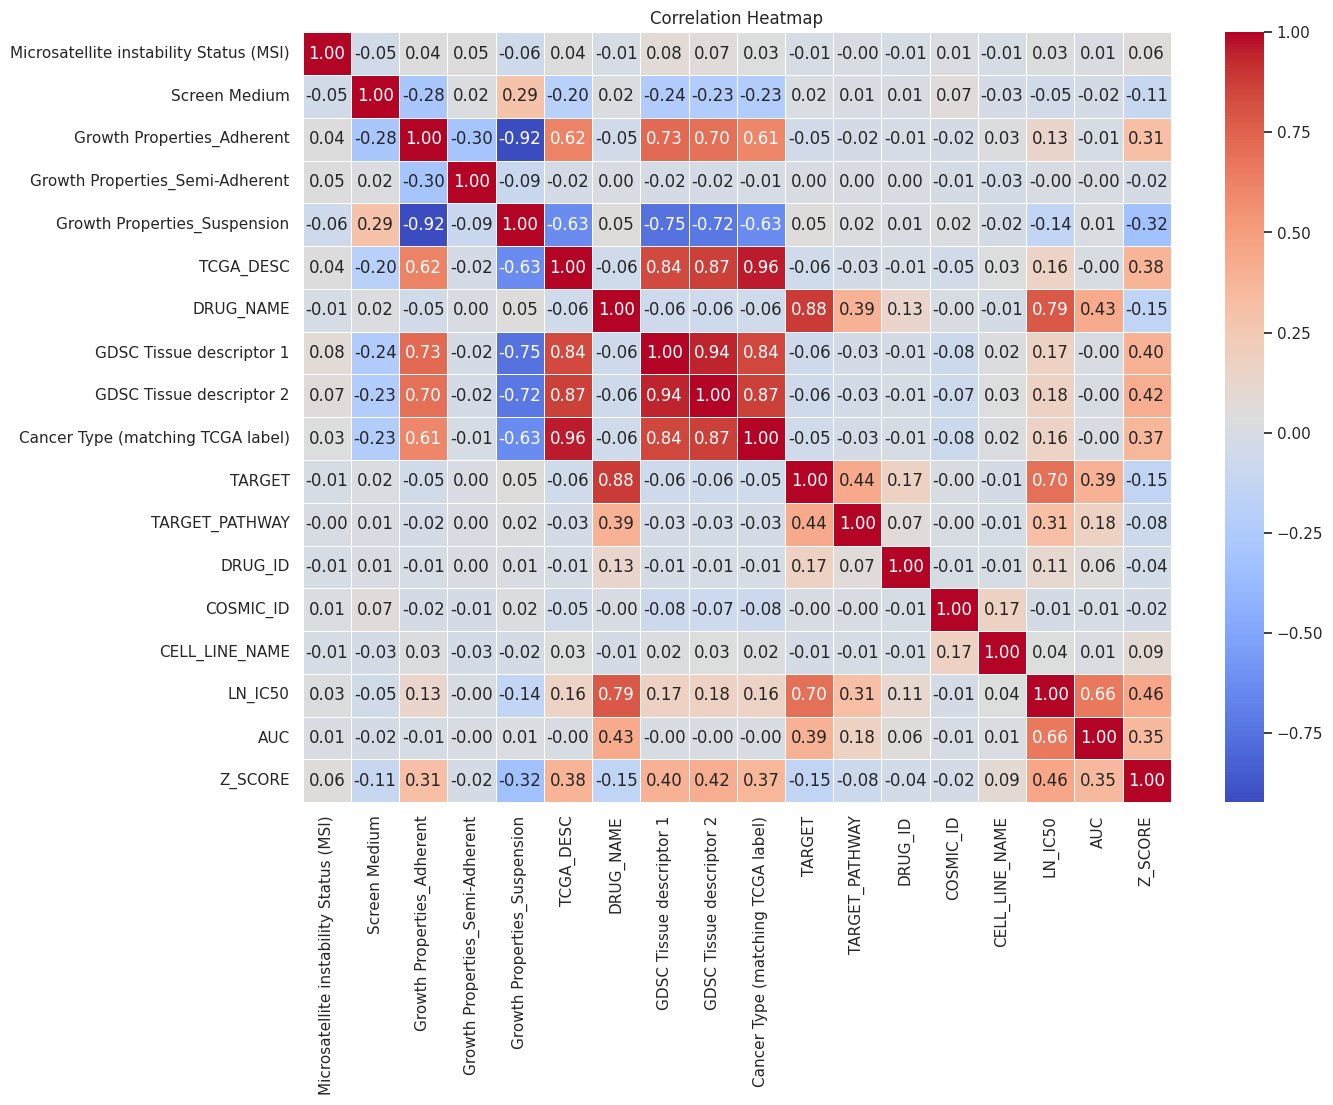

In [49]:
import seaborn as sns

# 1. Correlation Heatmap
corr = encoded_drugs.corr()
plt.figure(figsize=(1410))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show(), 

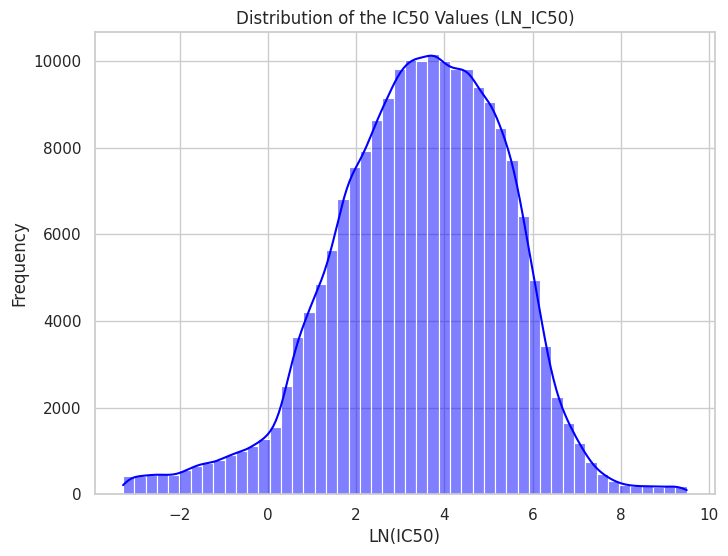

In [48]:
# 2. Distribution of Encoded IC50 Values
plt.figure(figsize=(8, 6))
sns.histplot(encoded_drugs['LN_IC50'], kde=True, bins=50, color='blue')
plt.title("Distribution of the IC50 Values (LN_IC50)")
plt.xlabel("LN(IC50)")
plt.ylabel("Frequency")
plt.show()

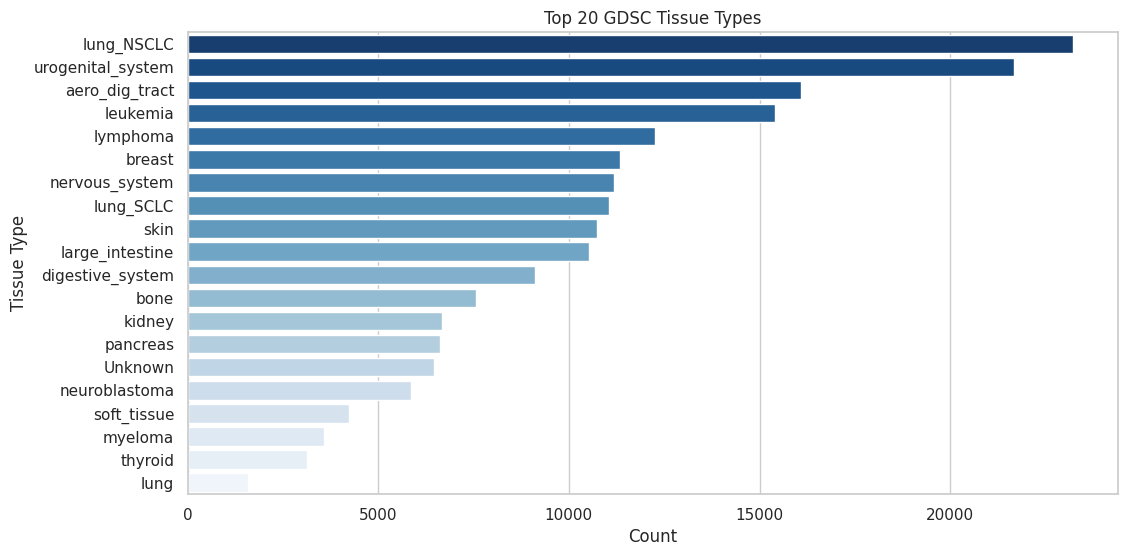

In [60]:
# 3. Horizontal Bar Chart for Top 20 GDSC Tissue Types
plt.figure(figsize=(12, 6))
tissue_counts = df_no_outliers['GDSC Tissue descriptor 1'].value_counts().nlargest(20)
sns.barplot(x=tissue_counts.values, y=tissue_counts.index, palette="Blues_r")
plt.title("Top 20 GDSC Tissue Types")
plt.xlabel("Count")
plt.ylabel("Tissue Type")
plt.show()

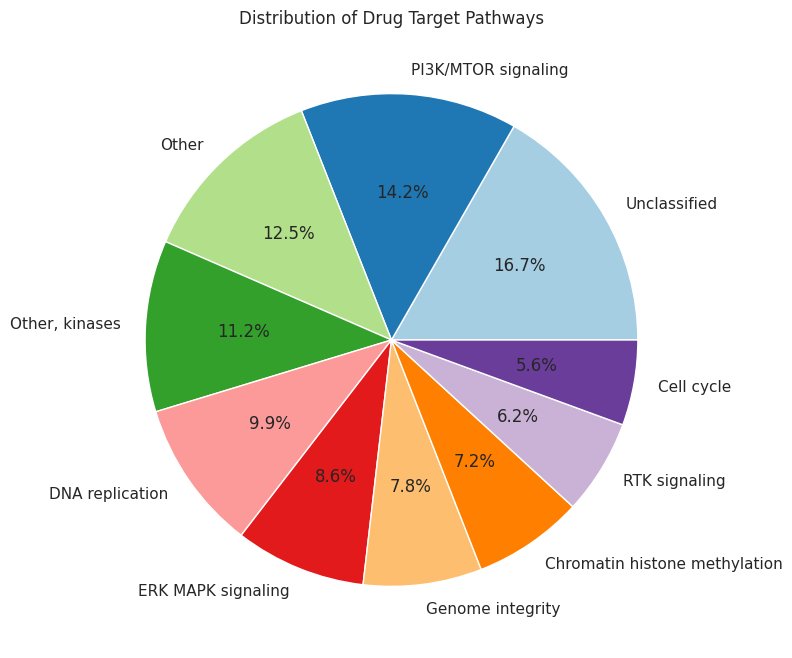

In [57]:
# 4. Pie Chart for Target Pathways Distribution
pathway_counts = df_no_outliers['TARGET_PATHWAY'].value_counts().nlargest(10)  # Top 10 for clarity

fig2, ax = plt.subplots(figsize=(8, 8))
ax.pie(pathway_counts, labels=pathway_counts.index, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
ax.set_title('Distribution of Drug Target Pathways')

plt.show()

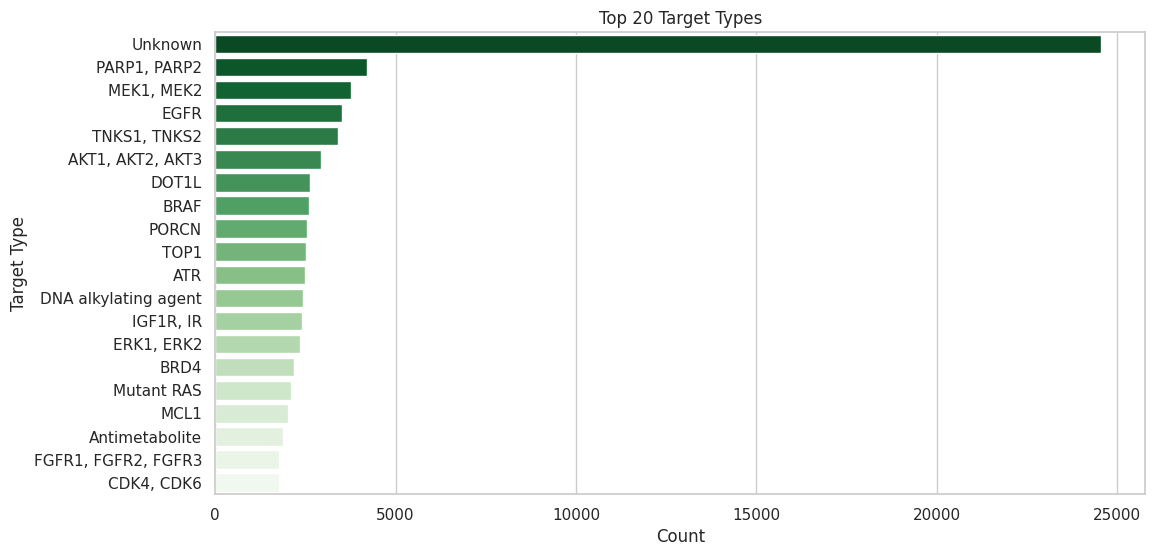

In [61]:
# 5. Horizontal Bar Chart for Top 20 Targets
plt.figure(figsize=(12, 6))
target_counts = df_no_outliers['TARGET'].value_counts().nlargest(20)
sns.barplot(x=target_counts.values, y=target_counts.index, palette="Greens_r")
plt.title("Top 20 Target Types")
plt.xlabel("Count")
plt.ylabel("Target Type")
plt.show()

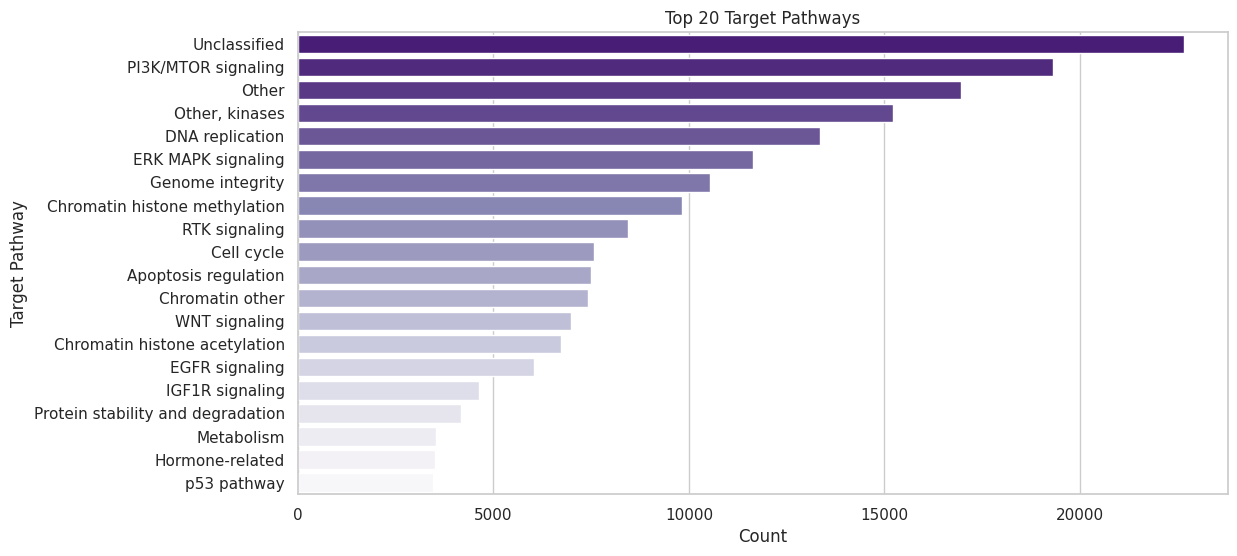

In [62]:
# 6. Horizontal Bar Chart for Target Pathways
plt.figure(figsize=(12, 6))
pathway_counts = df_no_outliers['TARGET_PATHWAY'].value_counts().nlargest(20)
sns.barplot(x=pathway_counts.values, y=pathway_counts.index, palette="Purples_r")
plt.title("Top 20 Target Pathways")
plt.xlabel("Count")
plt.ylabel("Target Pathway")
plt.show()

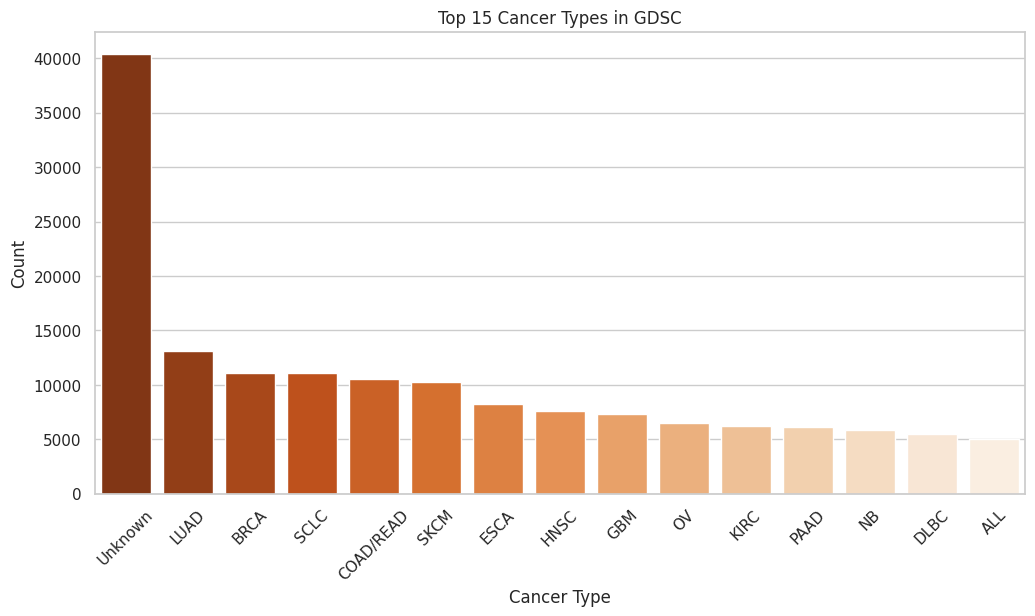

In [63]:
# 7. Bar Chart for Cancer Types Distribution
plt.figure(figsize=(12, 6))
cancer_counts = df_no_outliers['Cancer Type (matching TCGA label)'].value_counts().nlargest(15)
sns.barplot(x=cancer_counts.index, y=cancer_counts.values, palette="Oranges_r")
plt.title("Top 15 Cancer Types in GDSC")
plt.xlabel("Cancer Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

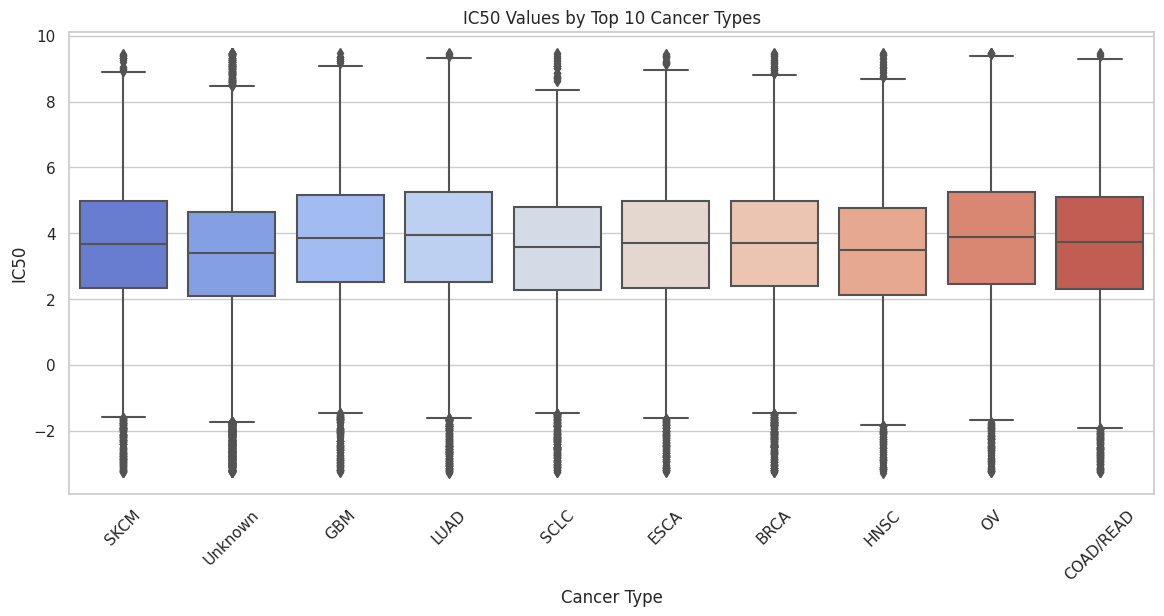

In [68]:
# 8. Boxplot of IC50 by Cancer Type
plt.figure(figsize=(14, 6))
top_cancers = df_no_outliers['Cancer Type (matching TCGA label)'].value_counts().nlargest(10).index
sns.boxplot(x=df_no_outliers[df_no_outliers['Cancer Type (matching TCGA label)'].isin(top_cancers)]['Cancer Type (matching TCGA label)'],
            y=df_no_outliers['LN_IC50'], palette="coolwarm")
plt.title("IC50 Values by Top 10 Cancer Types")
plt.xlabel("Cancer Type")
plt.ylabel("IC50")
plt.xticks(rotation=45)
plt.show()


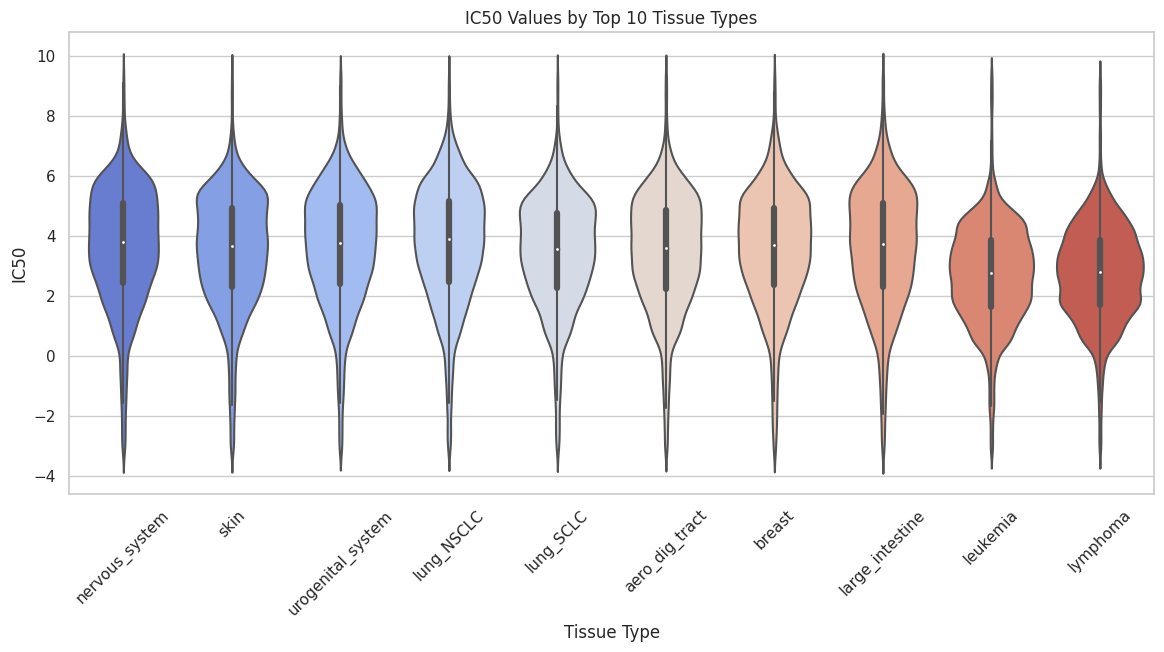

In [70]:
# 9. Violin Plot of IC50 by Tissue Type (Top 10)
plt.figure(figsize=(14, 6))
top_tissues = df_no_outliers['GDSC Tissue descriptor 1'].value_counts().nlargest(10).index
sns.violinplot(x=df_no_outliers[df_no_outliers['GDSC Tissue descriptor 1'].isin(top_tissues)]['GDSC Tissue descriptor 1'],
               y=df_no_outliers['LN_IC50'], palette="coolwarm")
plt.title("IC50 Values by Top 10 Tissue Types")
plt.xlabel("Tissue Type")
plt.ylabel("IC50")
plt.xticks(rotation=45)
plt.show()

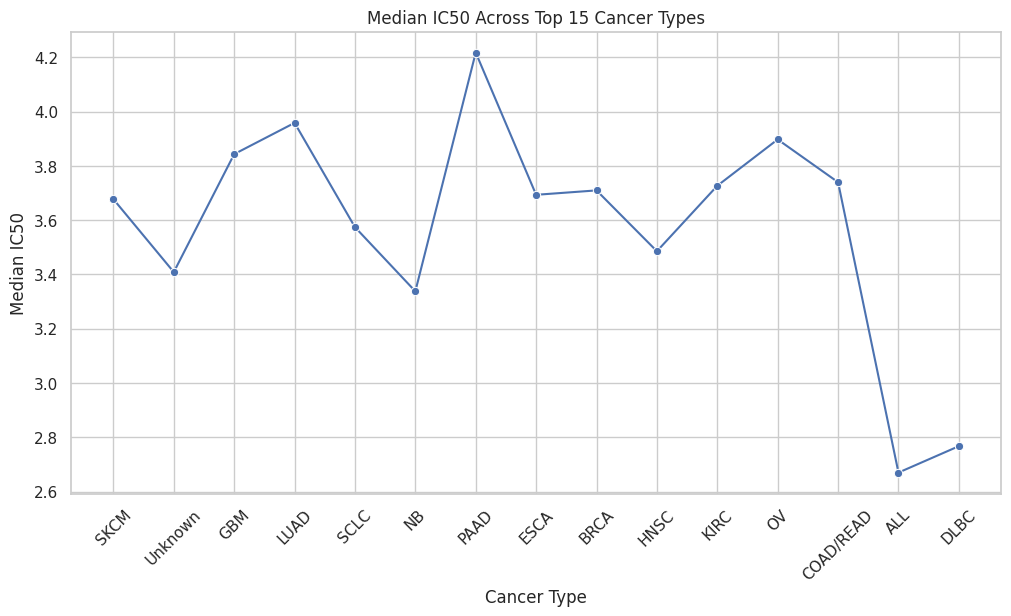

In [71]:
# 10. Line Plot for IC50 Distribution Over Top 15 Cancer Types
plt.figure(figsize=(12, 6))
top_cancers = df_no_outliers['Cancer Type (matching TCGA label)'].value_counts().nlargest(15).index
df_filtered = df_no_outliers[df_no_outliers['Cancer Type (matching TCGA label)'].isin(top_cancers)]
sns.lineplot(x="Cancer Type (matching TCGA label)", y="LN_IC50", data=df_filtered, estimator=np.median, marker="o", ci=None)
plt.title("Median IC50 Across Top 15 Cancer Types")
plt.xlabel("Cancer Type")
plt.ylabel("Median IC50")
plt.xticks(rotation=45)
plt.show()

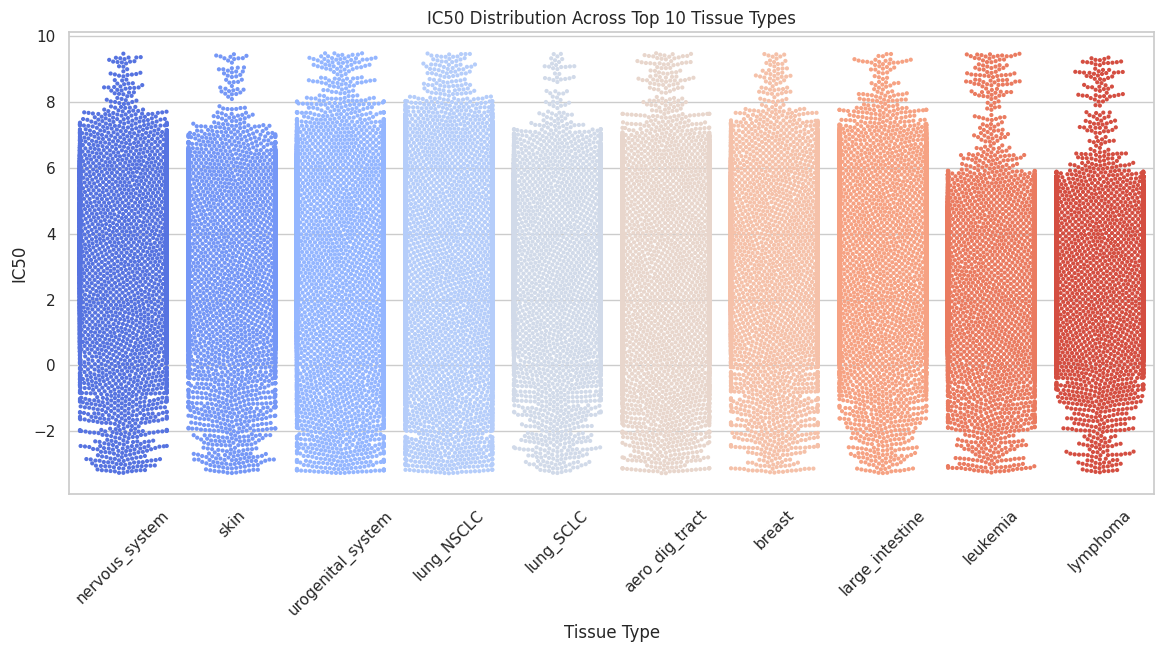

In [72]:
# 11. Swarm Plot of IC50 by Tissue Type (Top 10)
plt.figure(figsize=(14, 6))
top_tissues = df_no_outliers['GDSC Tissue descriptor 1'].value_counts().nlargest(10).index
df_filtered = df_no_outliers[df_no_outliers['GDSC Tissue descriptor 1'].isin(top_tissues)]
sns.swarmplot(x="GDSC Tissue descriptor 1", y="LN_IC50", data=df_filtered, palette="coolwarm", size=3)
plt.title("IC50 Distribution Across Top 10 Tissue Types")
plt.xlabel("Tissue Type")
plt.ylabel("IC50")
plt.xticks(rotation=45)
plt.show()

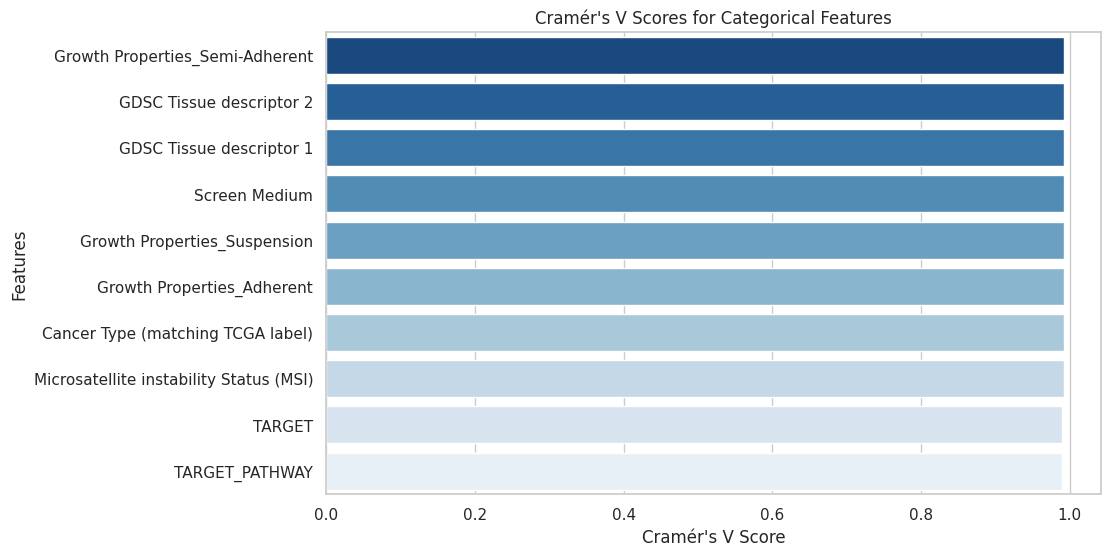

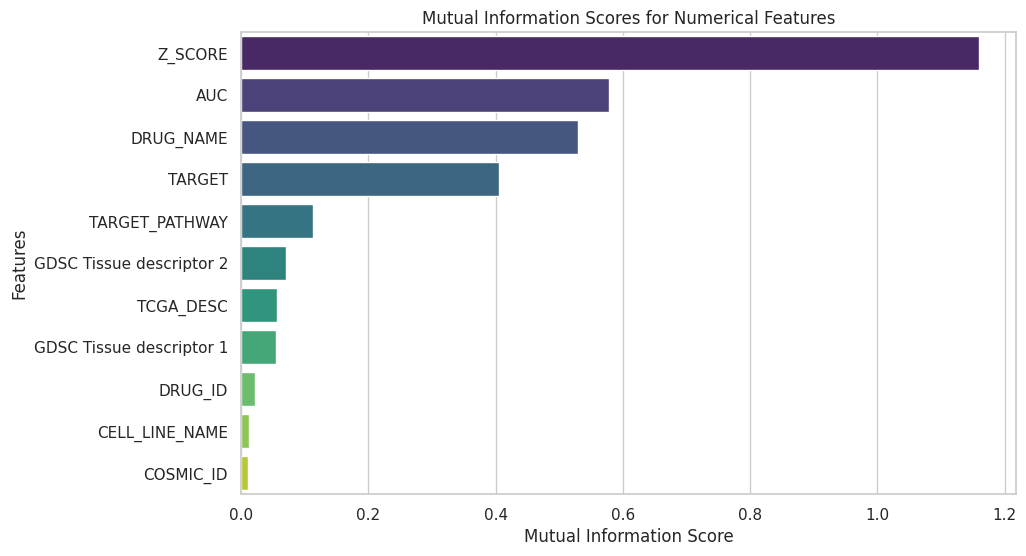

In [81]:
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import chi2_contingency

# Categorical features - these are the ones you want to calculate Cramér's V for
categorical_features = ['Microsatellite instability Status (MSI)', 'Screen Medium', 'Growth Properties_Adherent',
                        'Growth Properties_Semi-Adherent', 'Growth Properties_Suspension', 'TARGET',
                        'TARGET_PATHWAY', 'GDSC Tissue descriptor 1', 'GDSC Tissue descriptor 2', 
                        'Cancer Type (matching TCGA label)']

# Numerical features - these are the ones you want to calculate Mutual Information for
numerical_features = ['TCGA_DESC', 'DRUG_NAME', 'GDSC Tissue descriptor 1', 'GDSC Tissue descriptor 2', 
                      'TARGET', 'TARGET_PATHWAY', 'DRUG_ID', 'COSMIC_ID', 'CELL_LINE_NAME', 
                      'LN_IC50', 'AUC', 'Z_SCORE']

# Target variable
target_variable = 'LN_IC50'

# Cramér's V Calculation for Categorical Variables
def cramers_v(confusion_matrix):
    chi2, p, dof, expected = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()  # total sample size
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

# Calculate Cramér's V for each encoded categorical feature
cramers_v_scores = {}
for feature in categorical_features:
    # Create a contingency table between the encoded feature and the target
    contingency_table = pd.crosstab(encoded_drugs[feature], encoded_drugs[target_variable])
    
    # Calculate Cramér's V score
    cramers_v_scores[feature] = cramers_v(contingency_table)

# Create a pandas Series for sorting the Cramér's V scores
cramers_v_series = pd.Series(cramers_v_scores).sort_values(ascending=False)

# Plot the ranked Cramér's V scores
plt.figure(figsize=(10, 6))
sns.barplot(x=cramers_v_series.values, y=cramers_v_series.index, palette='Blues_r')
plt.title("Cramér's V Scores for Categorical Features")
plt.xlabel("Cramér's V Score")
plt.ylabel("Features")
plt.show()

# Mutual Information Calculation for Numerical Variables
X = encoded_drugs[numerical_features].drop(target_variable, axis=1)  # Features
y = encoded_drugs[target_variable]  # Target

# Calculate Mutual Information for each numerical feature
mutual_info_scores = {}
for feature in X.columns:
    mutual_info_scores[feature] = mutual_info_regression(X[[feature]], y)[0]

# Create a pandas Series for sorting the Mutual Information scores
mutual_info_series = pd.Series(mutual_info_scores).sort_values(ascending=False)

# Plot the ranked Mutual Information scores
plt.figure(figsize=(10, 6))
sns.barplot(x=mutual_info_series.values, y=mutual_info_series.index, palette='viridis')
plt.title("Mutual Information Scores for Numerical Features")
plt.xlabel("Mutual Information Score")
plt.ylabel("Features")
plt.show()